# **Chap 7. 앙상블 학습과 랜덤 포레스트**
---

  - `앙상블 학습`
    - 일련의 에측기로부터 예측을 수집하는 방법
  - `랜덤 포레스트`
    - 결정 트리의 앙상블

## **7.1 투표 기반 분류기**
  - 직접 투표 
    - 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것

  - 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(`VotingClassifier`)를 만들고 훈련시켜보자.

In [1]:
# 5장에서 소개한 moons 데이터셋
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

  - 각 분류기의 테스트셋 정확도를 확인해보자.

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


  - 예상대로 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높다.

---

## **7.2 배깅과 페이스팅**

  - 다양한 분류기를 만드는 방법 중 하나는, 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것이다.
    - `배깅`(Bagging)
      - 훈련 세트에서 `중복을 허용`하여 샘플링하는 방식
    - `페이스팅`(Pasting)
      - 훈련 세트에서 `중복을 허용하지 않고` 샘플링하는 방식
    - 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다. 하지만 `배깅만이` 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있다.

  - 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.

  - 수집 함수는 전형적으로 `분류`일 때는 `통계적 최빈값`, `회귀`에 대해서는 `평균`을 계싼한다.

  - 일반적으로 `앙상블의 결과는` 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 `편향은 비슷`하나 `분산은 줄어든다`.

### 7.2.1 사이킷런의 배깅과 페이스팅

  - 사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 `BaggingClassifier`(회귀의 경우 `BaggingRegressor`)를 제공한다.
  - 다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드이다. 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련된다. 이는 배깅의 경우로, 페이스팅을 사용하려면 bootstrap = False로 지정하면 된다.
  - `n_jobs` 매개변수는 사이킷런이 훈련과 예측에 `사용할 CPU 코어 수`를 지정한다. -1로 지정할 경우, 가능한 모든 코어를 사용한다.

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 100, bootstrap = True, n_jobs = -1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

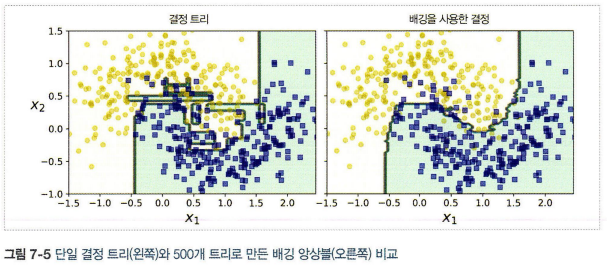

  - 그림 [7-5]를 통해 알 수 있듯이, 앙상블의 예측은 결정 트리 하나의 예측보다 일반화가 훨씬 잘된다. 즉, `앙상블`은 `비슷한 편향`에서 `더 작은 분산`을 만든다.
  - 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로, `배깅`이 페이스팅보다 `편향이 조금 더 높다`. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 `분산을 감소`시킨다.
  - 따라서 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호한다.

### 7.2.2 oob 평가

  - 배깅을 사용하면 어떤 샘플은 여러 번 샘플링되고, 어떤 것은 전혀 선택되지 않을 수 있다. BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플을 선택한다. 
  - 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미한다. 선택되지 않은 훈련 샘플의 나머지 37%를 oob(Out-Of-Bag) 샘플이라고 부른다. 
  - 별도의 검증 세트를 사용하지 않아도 oob 샘플을 사용해 평가할 수 있다. 

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

  - oob 평가 결과를 보면 이 BaggingClassifier는 테스트 세트에서 약 89.6%의 정확도를 얻을 것으로 보인다.

In [8]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.88

  - 테스트 세트에서 88%의 정확도를 얻었다. 이는 oob 평가 결과와 매우 비슷하다. 

  - oob 샘플에 대한 결정 함수의 값도 `oob_decision_function_` 변수에서 확인할 수 있다.

In [9]:
bag_clf.oob_decision_function_

array([[0.41      , 0.59      ],
       [0.28191489, 0.71808511],
       [1.        , 0.        ],
       [0.00598802, 0.99401198],
       [0.00537634, 0.99462366],
       [0.04891304, 0.95108696],
       [0.29015544, 0.70984456],
       [0.03414634, 0.96585366],
       [0.9895288 , 0.0104712 ],
       [0.94329897, 0.05670103],
       [0.78571429, 0.21428571],
       [0.        , 1.        ],
       [0.78333333, 0.21666667],
       [0.84293194, 0.15706806],
       [0.96022727, 0.03977273],
       [0.05181347, 0.94818653],
       [0.        , 1.        ],
       [0.98305085, 0.01694915],
       [0.92307692, 0.07692308],
       [1.        , 0.        ],
       [0.015     , 0.985     ],
       [0.36516854, 0.63483146],
       [0.91573034, 0.08426966],
       [1.        , 0.        ],
       [0.95811518, 0.04188482],
       [0.        , 1.        ],
       [0.99462366, 0.00537634],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.63387978, 0.36612022],
       [0.

---

## **7.3 랜덤 패치와 랜덤 서브스페이스**

  - 랜덤 패치 방식
    - 훈련 특성과 샘플을 모두 샘플링하는 것
    - 샘플링은 max_features, bootstrap_features 두 매개변수에 의해 조절

  - 랜덤 서브스페이스 방식
    - 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

  - 이러한 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

---

## **7.4 랜덤 포레스트**

  - `랜덤 포레스트`는 일반적으로 `배깅 방법을 적용한 결정 트리의 앙상블`이다.
    - `max_samples`를 `훈련 세트의 크기`로 지정
    - RandomForestClassifier, RandomForestRegressor를 사용해 랜덤 포레스트를 수행할 수 있다.
  - 다음은 500개의 트리로 이루어진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드이다.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

  - `랜덤 포레스트 알고리즘`은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신, 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다.
  - 이는 트리를 더욱 다양하게 만들고, `편향을 손해보는 대신 분산을 낮추어` 전체적으로 더 훌륭한 모델을 만들어낸다.
  - 다음은 BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 것이다.

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = 'auto', max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)

### 7.4.1 엑스트라 트리

  - `극단적으로 무작위한 트리의 랜덤 포레스트`를 익스트림 랜덤 트리 앙상블, 또는 줄여서 `엑스트라 트리(Extra-trees)`라고 부른다. 여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 된다.
  - 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다는 장점이 있다.
  - 엑스트라 트리를 만들기 위해서는 사이킷런의 `ExtraTreesClassifier`를 사용한다.

### 7.4.2 특성 중요도

  - `랜덤 포레스트`의 또 다른 장점은, `특성의 상대적 중요도를 측정하기 쉽다`는 것이다.
  - 평균적으로 `불순도를 얼마나 감소시키는지 확인`하여 특성의 중요도를 측정한다. 더 정확히 말하면 가중치 평균이며, 각 노드의 가중치는 연관된 훈련 샘플 수와 같다.
  - `feature_importances_` 변수를 통해 이를 확인해볼 수 있다. 

In [12]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10438513774307442
sepal width (cm) 0.021525823602987756
petal length (cm) 0.4345485390380268
petal width (cm) 0.439540499615911


  - iris 데이터셋을 훈련시킨 뒤, 각 특성의 중요도를 출력한 결과이다.
  - `가장 중요한 특성`은 `꽃잎의 길이`(43%)와 `너비`(44%)이고, 꽃받침의 길이와 너비는 비교적 덜 중요해보인다.
  - 이처럼 랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리하다.

---

## **7.5 부스팅**

  - `부스팅(Boosting)`
    - 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
    - 기본 아이디어 : 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
    - `에이다부스트(AdaBoost)`, `그레이디언트 부스팅(Gradient-Boosting)`이 가장 인기 있다.

### 7.5.1 에이다부스트

  - `에이다부스트(AdaBoost)`
    - 기본 아이디어 : 이전 예측기를 보완하는 새로운 예측기를 만들기 위해서는, `이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것`이다.
    - 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

  - 구체적인 알고리즘
    - 먼저 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만든다.
    - 그 다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
    - 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.
    - 그 다음에 다시 가중치를 업데이트하는 식으로 계속된다.
    - 이를 그림으로 나타내면 아래와 같다.

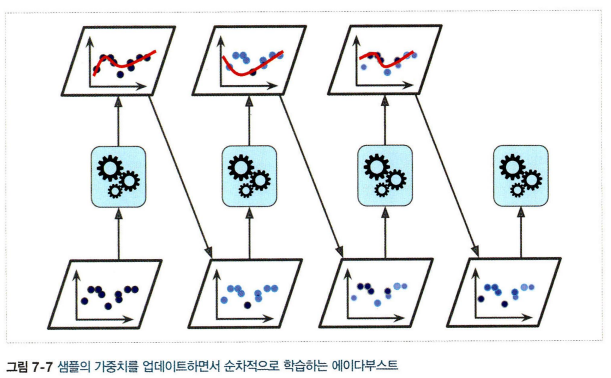

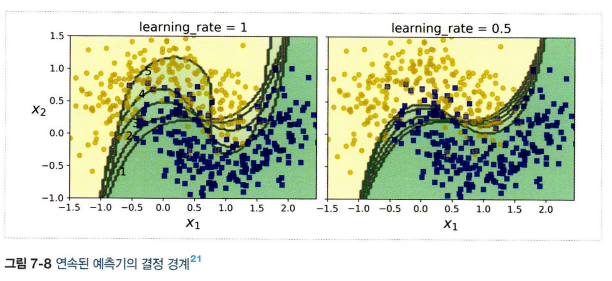

  - 그림 7-8은 moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계이다. 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌다. 따라서 두 번째 분류기는 이 샘플들을 더 정확하게 예측하게 된다.
  - 오른쪽 그래프는 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것이다. 
  - 그림에서 볼 수 있듯이, 이런 `연속된 학습 기법`은 `경사 하강법과 비슷`한 면이 있다. `경사 하강법`은 비용 함수를 최소화하기 위해 `한 예측기의 모델 파라미터를 조정`해가는 반면, `에이다부스트`는 점차 더 좋아지도록 `앙상블에 예측기를 추가`한다.

  - 에이다부스트 알고리즘
    1. j번째 예측기의 가중치가 적용된 에러율
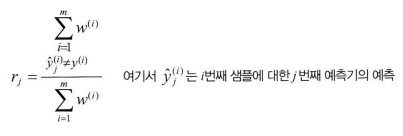
    2. 예측기 가중치
$$α_{j} = ηlog\frac{1-r_{j}}{r_{j}}$$
      - η : 학습률 하이퍼파라미터
      - 예측기가 정확할수록 가중치가 더 높아진다.
    3. 가중치 업데이트 규칙
  
  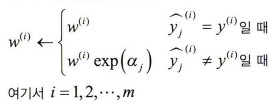
    - 3번 식을 이용해 샘플의 가중치를 업데이트한다. 즉, 잘못 분류된 샘플의 가중치가 증가된다. 그런 다음 모든 샘플의 가중치를 정규화한다.
    - 마지막으로 새 예측기가 업데이트된 가중치를 이용해 훈련되고 전체 과정이 반복된다.
    - 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지된다.

  4. 에이다부스트 예측

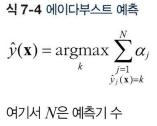

  - 예측을 할 때 에이다부스트는 단순이 모든 예측기의 예측을 계산하고 가중치 α_{j}를 더해 예측 결과를 만든다. 
  - 가중치 합이 가장 큰 클래스가 예측 결과가 된다.

  - 사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전을 사용한다. 클래스가 2개일 때는 SAMME가 에이다부스트와 동일하다.

In [13]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = 'SAMME.R', learning_rate = 0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

  - `그레이디언트 부스팅(Gradient Boosting)`
    - 에이다부스트와 동일하게 그레이디언트 부스팅은 앙상블에 `이전까지의 오차를 보정`하도록 `예측기를 순차적으로 추가`한다.
    - 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신, `이전 예측기가 만든 잔여 오차에 대한 새로운 예측기`를 학습시킨다.

  - 먼저 DecisionTreeRegressor를 훈련 세트에 학습시켜보자.

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

  - 이제 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련시킨다. 

In [15]:
y2 = y - tree_reg1.predict(X)     # 잔여 오차 = 첫 번째 모델 실제값 - 첫 번째 모델 예측값
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

  - 그런 다음 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련시킨다.

In [16]:
y3 = y2 - tree_reg2.predict(X)    # 잔여 오차 = 두 번째 모델 실제값 - 두 번째 모델 예측값 
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

  - 이렇게 해서 세 개의 트리를 포함하는 앙상블 모델이 생성되었다. 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 된다.

In [21]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

NameError: ignored

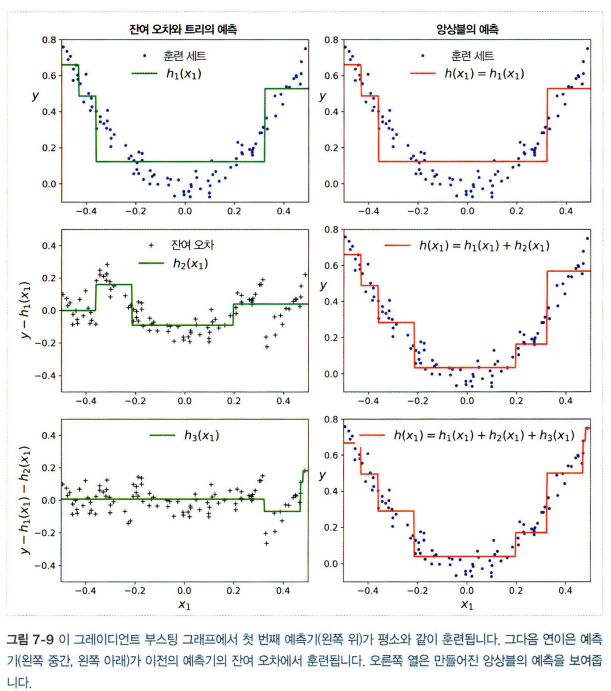

  - 그림 7-9의 `왼쪽` 열은 이 `세 트리의 예측`이고 `오른쪽` 열은 `앙상블의 예측`이다.
  - `첫 번째 행`에서는 앙상블에 트리가 하나만 있어서 `첫 번째 트리의 예측과 완전히 같다.`
  - `두 번째 행`에서는 `새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습`되었다. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같은 것을 볼 수 있다.
  - `세 번째 행`에서는 `또 다른 트리가 두 번째 트리의 잔여 오차에 훈련`되었다.
  - 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있다.

  - 사이킷런의 `GradientBoostingRegressor` 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있다.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

  - `learning_rate` : `각 트리의 기여 정도`를 조절
    - 이를 `낮게 설정`하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만, 일반적으로 `예측 성능은 좋아진다`. 이를 `축소`라고 부른다.

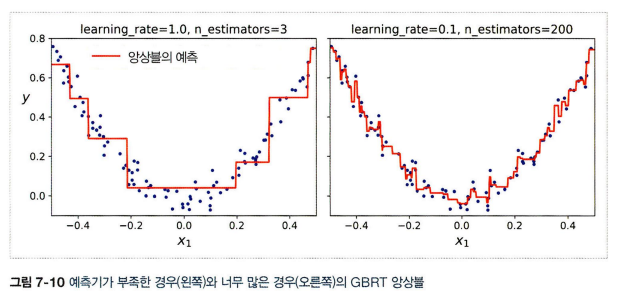

  - 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면, 오른쪽은 트리가 너무 많아훈련 세트에 과대적합되었다.

  - 이처럼 과소적합이나 과대적합을 방지하기 위해, `최적의 트리 수`를 찾을 수 있는 `조기 종료 기법`을 사용할 수 있다.
  - 간단하게 구현하려면 `staged_predict()` 메서드를 사용한다.
  - 다음 코드는 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다. 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킨다.

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=97)

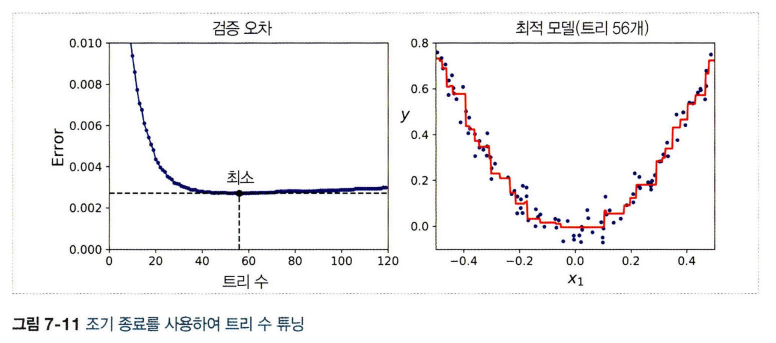

  - 그림 7-11의 왼쪽은 검증 오차이고 오른쪽은 최적 모델의 예측이다. 

  - 위의 방법 외에도 `실제로 훈련을 중지하는 방법`으로 `조기 종료를 구현`할 수도 있다.
  - `warm_start = True`로 설정하면 사이킷런이 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 한다.
  - 다음 코드는 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춘다. 

In [26]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break     # 조기 종료

  - XGBoost(Extreme Gradient Boosting)
    - 최적화된 그레이디언트 부스팅 구현 기법
    - 매우 빠른 속도, 확장성, 이식성을 가짐

In [27]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[05:56:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  - XGBoost는 자동 조기 종료와 같은 좋은 기능도 제공한다.

In [28]:
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X_val)

[05:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.46894
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.442376
[2]	validation_0-rmse:0.418672
[3]	validation_0-rmse:0.398116
[4]	validation_0-rmse:0.38101
[5]	validation_0-rmse:0.365387
[6]	validation_0-rmse:0.353608
[7]	validation_0-rmse:0.342152
[8]	validation_0-rmse:0.333861
[9]	validation_0-rmse:0.327207
[10]	validation_0-rmse:0.320668
[11]	validation_0-rmse:0.315916
[12]	validation_0-rmse:0.311547
[13]	validation_0-rmse:0.306445
[14]	validation_0-rmse:0.304022
[15]	validation_0-rmse:0.301005
[16]	validation_0-rmse:0.298342
[17]	validation_0-rmse:0.294571
[18]	validation_0-rmse:0.292621
[19]	validation_0-rmse:0.289037
[20]	validation_0-rmse:0.287312
[21]	validation_0-rmse:0.284525
[22]	validation_0-rmse:0.282858
[23]	validation_0-rmse:0.280731
[24]	validation_0-rmse:0.279484
[25]	validation_0-rms

---

## **7.6 스태킹**

  - 스태킹(stacking)
    - 기본 아이디어 : 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까?

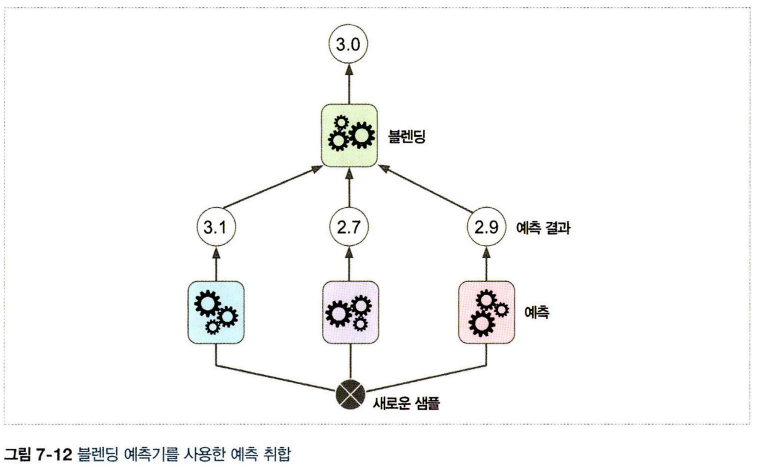

  - 블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용하는 것이다. 
  - 알고리즘
    - 먼저 훈련 세트를 두 개의 서브셋으로 나눈다. 이때 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용된다.

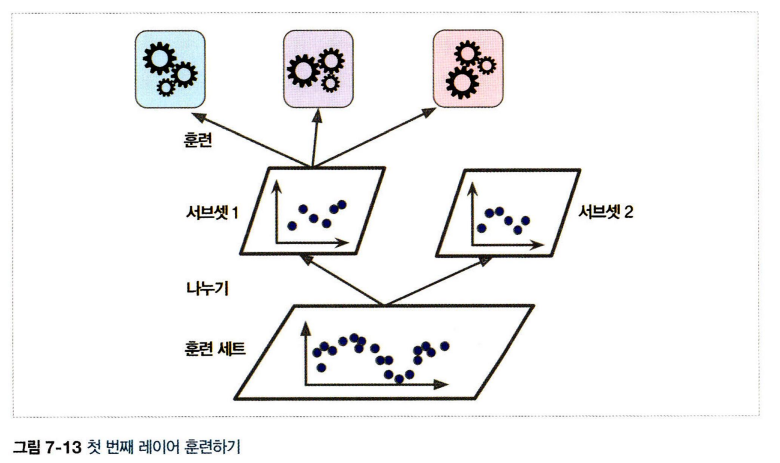

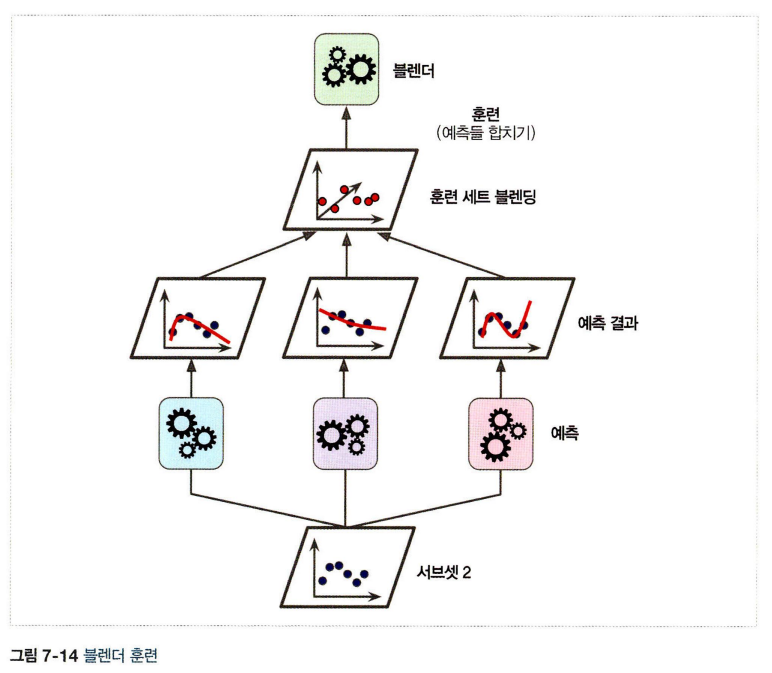

  - 그런 다음 첫 번째 레이어의 예측기를 사용해 두 번째 세트에 대한 예측을 만든다. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에, 이때 만들어진 예측은 완전히 새로운 것이다.
  - 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있다. 타깃값은 그대로 쓰고, 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다.
  - 블렌더가 새 훈련 세트로 훈련된다. 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습된다.